In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyvisa
import plotly.express as px
import pyvisa
import pandas as pd
from pathlib import Path
import matplotlib.patheffects as PathEffects
import scipy as sp
rm = pyvisa.ResourceManager()
SHIFT_REGISTER_SIZE = 16384
MAIN_PATH = "/Users/trevorpeyton/code/lbnl_2024/data"


#rm.open_resource("TCPIP::192.168.8.5::INSTR")
#failed to connect during test -- figure out whats going on

In [4]:
df = pd.read_csv(f"{MAIN_PATH}/runlogs/latest.csv")
# process test_type
# split test_type column into upset_type, config_0, config_1 and save each into it's own column
df[["upset_type", "config_0", "config_1"]] = df["test_type"].str.split("-", expand=True)

# add 6 columns to the right of each row with shift register data
for p in range(6):
    df[f"SR{p}"] = 0

# loop through each row
for i in range(df.shape[0]):

    row = df.iloc[i]

    # grab some useful variables for processing
    run = row["run"]
    upset_type = row["upset_type"]
    config_0 = row["config_0"]
    config_1 = row["config_1"]


    if upset_type == "seu":
        # process shift register data
        try:
            with open(f"{MAIN_PATH}/runs/{run}/shift.txt", "r") as f:
                data = np.stack([np.fromiter(line.strip(), dtype=np.int64) for line in f])
            data = data.T

            # add shift register data to row
            for p in range(6):
                    if config_0 == "h":
                        if config_1 == "1":
                            df.iloc[i, -6+p] = SHIFT_REGISTER_SIZE - data[p].sum()
                        if config_1 == "0":
                            df.iloc[i, -6+p] = data[p].sum()
                        if config_1 == "01":
                            mask = np.array([0, 1]*(SHIFT_REGISTER_SIZE//len([0, 1])))
                            masked_data = np.logical_xor(data[p], mask)
                            df.iloc[i, -6+p] = masked_data.sum()
        except:
            print(f"Skipping row {run} due to error in shift file.")
            continue
    # elif upset_type == "set":
    #     data_list = []
    #     for f in Path(f"data_06/runs/{run}").iterdir():
    #         if f.is_file() and f.suffix == '.txt' and not f.name == "log.txt":
    #             data_list.append([])
    #             with open(f, "r") as file:
    #                 for line in file:
    #                     data_list[-1].append(np.fromiter(line.strip(), dtype=np.int64))
    #     stacked_data = np.stack(data_list)
    #     stacked_sum = stacked_data.sum(axis=1)
    #     stacked_sum[stacked_sum == 32 | stacked_sum == 0] = 0
    #     thresholds = stacked_sum.mean(axis=0) + 3*stacked_sum.std(axis=0)
    #     stacked_sum[stacked_sum > thresholds] = 0

# calculate cross section curves
for p in range(6):
    df[f"CSSR{p}"] = df[f"SR{p}"] / df["flux"]

Skipping row 125 due to error in shift file.
Skipping row 172 due to error in shift file.


In [7]:
df.columns

Index(['run', 'part', 'ion', 'let', 'angle', 'test_type', 'start_time',
       'start_date', 'end_time', 'end_date', 'transients', 'flux',
       'test/error', 'upset_type', 'config_0', 'config_1', 'SR0', 'SR1', 'SR2',
       'SR3', 'SR4', 'SR5', 'CSSR0', 'CSSR1', 'CSSR2', 'CSSR3', 'CSSR4',
       'CSSR5'],
      dtype='object')

In [10]:
# and not test/error
df[(df["upset_type"] == "seu") & (df["test/error"] != True)].shape[0]

123

In [15]:
df[(df["upset_type"] == "seu") & (df["test/error"] != True)].part.unique()

array(['2P(1)', '3T(5)', '1L(1)', '6M(5)'], dtype=object)

In [11]:
df[(df["upset_type"] == "set") & (df["test/error"] != True)].shape[0]

61

In [3]:
part_disabled_lookup = {
    "2P(1)": [True, True, True, True, True, True], # all shift registers working
    "4M(5)": [False, False, False, False, False, False], # all shift register not working (we never tested shift registers here)
    "3T(5)": [False, True, True, True, True, True], # first shift register broken
    "1L(1)": [False, True, True, True, True, True],
    "6M(5)": [False, True, True, True, True, True],
}

In [15]:
seu_subset = df[df["upset_type"] == "seu"]
# only take cross section values where the part is enabled
# we are only looking at CSSR0, so we only need to take the first value of the lookup
seu_subset = seu_subset[seu_subset["part"].map(lambda x: part_disabled_lookup[x][0])]
# only take where CSSR0 is >0
seu_subset = seu_subset[seu_subset["CSSR0"] > 0]

In [25]:
fig = px.scatter(seu_subset,
           x="let",
           y="CSSR0",
           color="config_0",
           title="LET vs. Cross Section for SEU",
           hover_data=["run", "config_1"], log_y=True,
           facet_col="config_1",
           trendline="ols"#, trendline_options=dict(log_y=True)
    )
    
fig.update_layout(yaxis_tickformat=".2e")
# show weibull fit on plot
fig.show()

In [248]:
run = 1
data_list = []
for f in Path(f"{MAIN_PATH}/runs/{run}").iterdir():
    if f.is_file() and f.suffix == '.txt' and not f.name == "log.txt":
        data_list.append([])
        with open(f, "r") as file:
            for line in file:
                data_list[-1].append(np.fromiter(line.strip(), dtype=np.int64))
stacked_data = np.stack(data_list)

In [250]:
stacked_data.shape

(131, 32, 4)

In [251]:
stacked_sum = stacked_data.sum(axis=1)
stacked_sum[(stacked_sum == 32) | (stacked_sum == 0)] = 0
thresholds = stacked_sum.mean(axis=0) + 3*stacked_sum.std(axis=0)
stacked_sum[stacked_sum > thresholds] = 0

In [268]:
# get value counts for each TDC
tdc_counts = [np.unique(stacked_sum[:, n], return_counts=True) for n in range(4)]

# generate a dataframe for plotly express
tdc_df = pd.DataFrame({
    "TDC": np.repeat(np.arange(4), 32),
    "Value": np.tile(np.arange(32), 4),
    "Count": np.concatenate([c[1] for c in tdc_counts])
})

In [265]:
# plotly bar plot
px.bar(x=tdc_counts[0], y=tdc_counts[1], labels={"x": "TDC", "y": "Hits"}, title="TDC Hit Counts")

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'TDC=%{x}<br>Hits=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': '',
              'offsetgroup': '',
              'orientation': 'v',
              'showlegend': False,
              'textposition': 'auto',
              'type': 'bar',
              'x': array([0, 2, 3, 4, 5, 6]),
              'xaxis': 'x',
              'y': array([338,  49,  89,  39,   8,   1]),
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'TDC Hit Counts'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'TDC'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Hits'}}}
})

In [242]:
def vis_full_shift_register(run, df, save_path=None, show=True):
    try:
        row = df.iloc[run]
        
        with open(f"data/runs/{run}/shift.txt", "r") as f:
            data = np.stack([np.fromiter(line.strip(), dtype=np.int64) for line in f])
        data = data.T.reshape(6, -1)

        fig, ax = plt.subplots(2, 3, figsize=(14, 10))
        # add some quick information to plot title
        fig.suptitle(f"Run {run} - Part {row['part']} - ION {row['ion']} - Fluence {row['flux']:.2e} - Shifted {row['config_1']} - Total SEUs {int(row['transients'])}", fontsize=20)
        ax = ax.flatten()
        for p in range(6):
            im_data = data[p]
            if row["upset_type"] == "seu":
                if row["config_0"] == "h":
                    if row["config_1"] == "1":
                        im_data = np.logical_not(im_data)
                    elif row["config_1"] == "0":
                        pass
                    elif row["config_1"] == "01":
                        mask = np.array([0, 1]*(SHIFT_REGISTER_SIZE//len([0, 1])))
                        im_data = np.logical_xor(im_data, mask)
            ax[p].imshow(
                im_data.reshape(-1, 128), aspect="auto", vmin=0, vmax=1, interpolation="none"
            )
            ax[p].set_yticks([])
            ax[p].set_xticks([])
            ax[p].set_ylabel(f"SR{p}", rotation=90, position=(1, 0.5), ha='right', va='bottom', fontsize=20)

            upset_count = row[f"SR{p}"]
            txt = ax[p].text(1, 1, f"Upsets: {upset_count}", ha='right', va='top', transform=ax[p].transAxes, fontsize=20, color="white")
            txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='black')])

        fig.tight_layout()

        if save_path:
            fig.savefig(save_path, dpi=300, bbox_inches="tight")
        
        if show:
            fig.show()
    except Exception as e:
        print(e)

def vis_single_shift_register(run, sr, df):
    try:
        row = df.iloc[run]
        upset_count = row[f"SR{sr}"]


        with open(f"data/runs/{run}/shift.txt", "r") as f:
            data = np.stack([np.fromiter(line.strip(), dtype=np.int64) for line in f])
        data = data.T.reshape(6, -1, 128)

        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

        # instead of showing raw data, we only want to see where the bits are upset
        # for a test type of h 0, this means anywhere a 1 is present
        if row["upset_type"] == "seu":
            if row["config_0"] == "h":
                if row["config_1"] == "1":
                    ax.imshow(
                        data[sr].logical_not(), aspect='equal', vmin=0, vmax=1, interpolation="none"
                    )
                elif row["config"] == "0":
                    ax.imshow(
                        data[sr], aspect='equal', vmin=0, vmax=1, interpolation="none"
                    )
                elif row["config"] == "01":
                    mask = np.array([0, 1]*(SHIFT_REGISTER_SIZE//len([0, 1])))
                    masked_data = np.logical_xor(data[sr], mask)
                    ax.imshow(
                        masked_data, aspect='equal', vmin=0, vmax=1, interpolation="none"
                    )
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_ylabel(f"SR{sr}", rotation=90, position=(1, 0.5), ha='right', va='bottom', fontsize=20)

        row = df.iloc[run]
        upset_count = row[f"SR{sr}"]
        txt = ax.text(1, 1, f"Upsets: {upset_count}", ha='right', va='top', transform=ax.transAxes, fontsize=20, color="white")
        txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='black')])

        fig.tight_layout()
        fig.show()
    except Exception as e:
        print(e)

In [ ]:
# loop through all SEU runs
for i in range(df.shape[0]):
    row = df.iloc[i]
    if row["upset_type"] == "seu":
        vis_full_shift_register(i, df, f"data/figs/shift_registers/{i}.png")

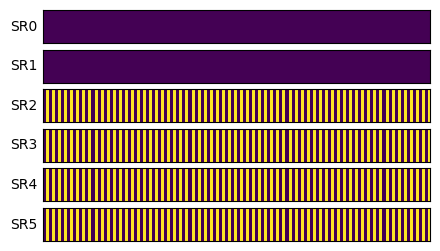

In [67]:
with open(f"data/runs/11/shift.txt", "r") as f:
    data = np.stack([np.fromiter(line.strip(), dtype=np.int64) for line in f])
data = data.T.reshape(6, -1, 128)

fig, ax = plt.subplots(6, 1, figsize=(5, 3))
for p in range(6):
    # ax[p].set_title(f"Shift Register {p}", loc="right")
    # ax[p].set_title(f"{p}", rotation=-90, position=(1.01, 0.5), ha='center', va='center')
    ax[p].imshow(
        data[p], aspect="auto", vmin=0, vmax=1, interpolation="none"
    )
    ax[p].set_yticks([])
    ax[p].set_xticks([])
    ax[p].set_ylabel(f"SR{p}", rotation=0, position=(1.01, 0.5), ha='right', va='center')

# fig.tight_layout()
plt.show()

In [7]:
import pyvisa
rm = pyvisa.ResourceManager()
power_supply = rm.open_resource('TCPIP0::192.168.4.3::INSTR')

In [1]:
# Base64 Encoder - encodes a folder of PNG files and creates a .py file with definitions
import PySimpleGUI as sg
import os
import base64

'''
    Make base64 images
    input:  folder with .png .ico .gif 's
    output: output.py file with variables
    
    Copyright 2023 PySimpleSoft, Inc. and/or its licensors. All rights reserved.
    
    Redistribution, modification, or any other use of PySimpleGUI or any portion thereof is subject to the terms of the PySimpleGUI License Agreement available at https://eula.pysimplegui.com.
    
    You may not redistribute, modify or otherwise use PySimpleGUI or its contents except pursuant to the PySimpleGUI License Agreement.
'''

def main():
    OUTPUT_FILENAME = 'output.py'

    folder = sg.popup_get_folder('Source folder for images\nImages will be encoded and results saved to %s'%OUTPUT_FILENAME,
                               title='Base64 Encoder')

    if not folder:
        sg.popup_cancel('Cancelled - No valid folder entered')
        return
    try:
        namesonly = [f for f in os.listdir(folder) if f.endswith('.png') or f.endswith('.ico') or f.endswith('.gif')]
    except:
        sg.popup_cancel('Cancelled - No valid folder entered')
        return

    outfile = open(os.path.join(folder, OUTPUT_FILENAME), 'w')

    for i, file in enumerate(namesonly):
        contents = open(os.path.join(folder, file), 'rb').read()
        encoded = base64.b64encode(contents)
        outfile.write('\n{} = {}'.format(file[:file.index(".")], encoded))
        sg.OneLineProgressMeter('Base64 Encoding', i+1, len(namesonly), key='-METER-')

    outfile.close()
    sg.popup('Completed!', 'Encoded %s files'%(i+1))

if __name__ == '__main__':
    main()

: 

In [76]:
CH1 = "P6V"
CH2 = "P25V"
CH3 = "N25V"

def channel_state(channel, state):
    power_supply.write(f"INST {channel}")
    power_supply.write(f"OUTP {state}")

def set_voltage(channel, voltage):
    power_supply.write(f"INST {channel}")
    power_supply.write(f"VOLT {voltage}")

def set_current(channel, current):
    power_supply.write(f"INST {channel}")
    power_supply.write(f"CURR {current}")

def get_voltage(channel):
    return power_supply.query(f"MEAS:VOLT? {channel}")

def get_current(channel):
    power_supply.write(f"INST {channel}")
    return power_supply.query("MEAS:CURR?")

In [83]:
# one line to set CH1 to 2V
power_supply.write("VOLT ")

15

In [2]:
power_supply.close()

NameError: name 'power_supply' is not defined

In [74]:
channel_state("CH1", "ON")

In [80]:
get_voltage("CH1")

VisaIOError: VI_ERROR_IO (-1073807298): Could not perform operation because of I/O error.

In [9]:
power_supply.write("SYSTem:BEEPer:STATe 0")

23

In [56]:
arr = []
for i in range(0, 100):
    set_voltage(CH1, i)
    arr.append(get_current(CH1))

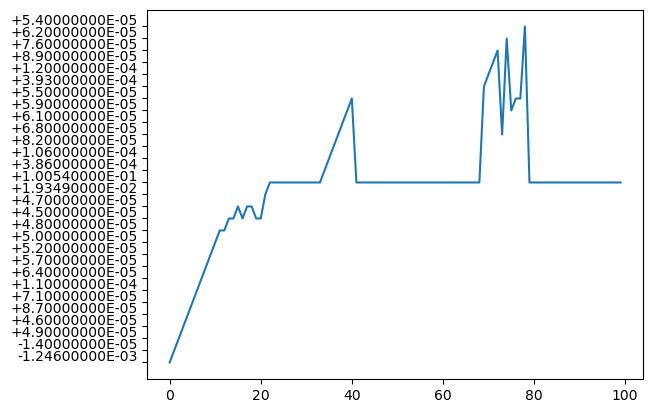

In [54]:
plt.plot(arr)
plt.show()

In [28]:
channel_state(CH1, "OFF")

In [11]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import scipy as sp
import time

path = "data/runs/100/shift.txt"

In [20]:
from keithley2600 import Keithley2600

# k = Keithley2600('TCPIP0::192.168.2.121::INSTR')

k = Keithley2600('TCPIP0::192.168.4.11::INSTR')

In [21]:
k.connect()

True

In [23]:
k.smua.source.output = k.smua.OUTPUT_ON
time.sleep(.25)
k.smua.source.levelv = 3.3
time.sleep(.25)
k.smub.source.output = k.smua.OUTPUT_ON
time.sleep(.25)
k.smub.source.levelv = 1.2
time.sleep(.25)


In [18]:
k.smua.source.output = k.smua.OUTPUT_OFF
time.sleep_ms(500)
k.smub.source.output = k.smua.OUTPUT_OFF
time.sleep_ms(500)

In [24]:
k.disconnect()

In [16]:
k.smua.source.output = k.smua.OUTPUT_ON
k.smua.source.levelv = 3.3
k.smub.source.output = k.smua.OUTPUT_ON
k.smub.source.levelv = 1.2
# k.smua.source.output = k.smua.OUTPUT_OFF
# k.smub.source.output = k.smub.OUTPUT_OFF

TypeError: cannot unpack non-iterable int object

In [3]:
k.smua.source.output = k.smua.OUTPUT_ON   # turn on SMUA
k.smua.source.levelv = -2  # sets SMUA source level to -40V
v = k.smua.measure.v()  # measures and returns the SMUA voltage
i = k.smua.measure.i()  # measures current at smuA

k.smua.measure.v(k.smua.nvbuffer1)  # measures the voltage, stores the result in buffer
k.smua.nvbuffer1.clear()  # clears nvbuffer1 of SMUA

# turn off
k.smua.source.output = k.smua.OUTPUT_OFF

In [4]:
k.disconnect()

In [23]:
# file looks like 0000 where each 0 or 1 is a bit
with open("/Users/trevorpeyton/code/lbnl_2024/data/runs/3/2.txt", "r") as f:
    data = np.stack([np.fromiter(line.strip(), dtype=np.int64) for line in f])


In [29]:
run = 10
data_list = []

for f in Path(f"data/runs/{run}").iterdir():
    if f.is_file() and f.suffix == '.txt' and not f.name == "log.txt":
        data_list.append([])
        with open(f, "r") as file:
            for line in file:
                data_list[-1].append(np.fromiter(line.strip(), dtype=np.int64))
stacked_data = np.stack(data_list)

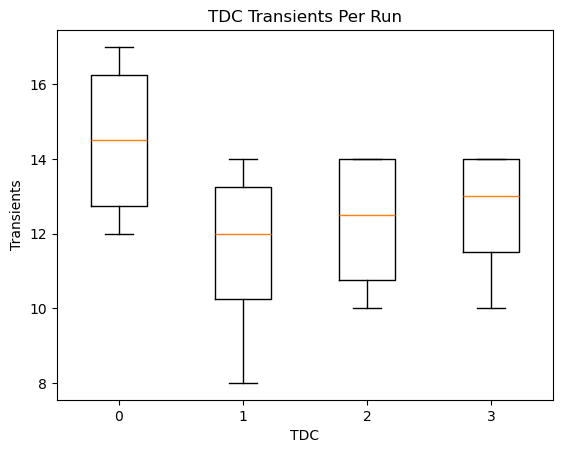

In [51]:
# box plot for last dimension
# split on first dimension
plt.title("TDC Transients Per Run")
plt.xlabel("TDC")
plt.ylabel("Transients")
plt.boxplot(stacked_data.sum(axis=1), labels=[f"{i}" for i in range(4)])
plt.show()

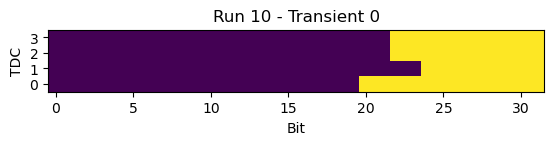

In [47]:
# y axis bottom up
transient = 0
plt.imshow(stacked_data[transient, :].T, vmin=0, vmax=1, interpolation='none')
plt.title(f"Run {run} - Transient {transient}")
plt.ylabel("TDC")
plt.yticks(np.arange(0, 4))
plt.xlabel("Bit")
plt.gca().invert_yaxis()
plt.show()

In [11]:
import pathlib
run = 3
counts = np.zeros(4)
for f in pathlib.Path(f"data/runs/{run}").iterdir():
    if f.name == "log.txt":
        continue
    with open("/Users/trevorpeyton/code/lbnl_2024/data/runs/3/2.txt", "r") as f:
        data = np.stack([np.fromiter(line.strip(), dtype=np.int64) for line in f])
    if f.is_file() and f.name != "log.txt":
        counts += 1
    # create a histogram for each
    # data = np.stack([np.fromiter(line.strip(), dtype=np.int64) for line in f])
    with f.open() as f:
        print()
        data = np.stack([np.fromiter(line.strip(), dtype=np.int64) for line in f.read()])
    print(data)
    data.T.sum(axis=1)
    counts += data.T.sum(axis=1)

[array([0]), array([0]), array([0]), array([0]), array([], dtype=int64), array([0]), array([0]), array([0]), array([0]), array([], dtype=int64), array([0]), array([0]), array([0]), array([0]), array([], dtype=int64), array([0]), array([0]), array([0]), array([0]), array([], dtype=int64), array([0]), array([0]), array([0]), array([0]), array([], dtype=int64), array([0]), array([0]), array([0]), array([0]), array([], dtype=int64), array([0]), array([0]), array([0]), array([0]), array([], dtype=int64), array([0]), array([0]), array([0]), array([0]), array([], dtype=int64), array([0]), array([0]), array([0]), array([0]), array([], dtype=int64), array([0]), array([0]), array([0]), array([0]), array([], dtype=int64), array([0]), array([0]), array([0]), array([0]), array([], dtype=int64), array([0]), array([0]), array([0]), array([0]), array([], dtype=int64), array([0]), array([0]), array([0]), array([0]), array([], dtype=int64), array([0]), array([0]), array([0]), array([0]), array([], dtype

ValueError: need at least one array to stack

In [2]:
import scipy as sp
import numpy as np

In [117]:
with open("/Users/trevorpeyton/code/lbnl_2024/data/runs/2/shift.txt", "r") as f:
    data = np.stack([np.fromiter(line.strip(), dtype=np.int64) for line in f]).T

In [118]:
# mask = shift_data * (a.shape[1] // len(shift_data))
mask = np.array(shift_data * (data.shape[1] // len(shift_data)))[None].repeat(
            6, axis=0
        )
if mask.shape[1] < data.shape[1]:
    masked_data = np.logical_xor(data[:, :-1], mask)
else:
    masked_data = np.logical_xor(data, mask)

In [81]:
shift_data = [0, 1]
with open("/Users/trevorpeyton/code/lbnl_2024/data/runs/3/shift.txt", "r") as f:
    data = np.stack([np.fromiter(line.strip(), dtype=np.int64) for line in f]).T
mask = np.array(shift_data*(SHIFT_REGISTER_SIZE//len(shift_data)))[None].repeat(6, axis=0)
# XOR to check for errors
masked_data = np.logical_xor(data, mask)
counts = masked_data.sum(axis=1)
print(counts)

[8192 8192 8192 8192 8192 8192]


In [58]:
from constants import *

In [32]:
shift_data = [0, 1]
mask = np.repeat(shift_data*(SHIFT_REGISTER_SIZE//len(shift_data)), 6)
# AND the data with the mask
masked_data = data & mask
# count sum
counts = masked_data.sum(axis=1)

ValueError: operands could not be broadcast together with shapes (16384,6) (98304,) 

In [15]:
data[data == 0] = -1
kernel = np.array([1])
kernel[kernel == 0] = -1
kernel = kernel.reshape(-1, 1)
result = sp.signal.convolve2d(
    data, kernel, mode="valid"
)
np.repeat([16384], 6) - np.sum(result != 0, axis=0)

array([32768, 32768, 32768, 32768, 32768, 32768])

In [12]:
np.repeat([16383], 6)

array([16383, 16383, 16383, 16383, 16383, 16383])

In [8]:
# convolve to find the number of times the kernel doesn't match
result = sp.signal.convolve2d(
    data, kernel, mode="valid"
)

In [9]:
result

array([[ 2,  2,  2,  2,  2,  2],
       [-2, -2, -2, -2, -2, -2],
       [ 2,  2,  2,  2,  2,  2],
       ...,
       [ 2,  2,  2,  2,  2,  2],
       [-2, -2, -2, -2, -2, -2],
       [ 2,  2,  2,  2,  2,  2]])

In [3]:
np.zeros(4)

array([0., 0., 0., 0.])

In [10]:
print(np.sum(result != 0, axis=0))
# data = np.stack([np.fromiter(line.strip(), dtype=np.int64) for line in f])
# # 16384, 6
# # reshape into 6, 128x128 arrays
# data = data.T.reshape(-1, 128, 128)
# for i in range(6):
#     plt.imshow(data[i], cmap="copper")
#     plt.show()
# plt.savefig("data/0_f_k_2_SET_2-58-8_2024-10-10.png")

[16383 16383 16383 16383 16383 16383]


In [125]:
import numpy as np
import matplotlib.pyplot as plt

In [133]:
with open(f"data/runs/3/shift.txt", "r") as f:
    data = np.stack([np.fromiter(line.strip(), dtype=np.int64) for line in f])

In [137]:
if data.shape[0] <= SHIFT_REGISTER_SIZE:
    # pad the data with zeros
    print(np.pad(data, ((0, SHIFT_REGISTER_SIZE - data.shape[0]), (0, 0))).shape)
elif data.shape[0] > SHIFT_REGISTER_SIZE:
    # truncate the data
    print(data[:SHIFT_REGISTER_SIZE].shape)

(16384, 6)


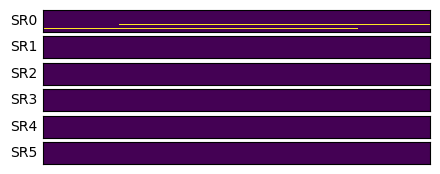

In [138]:
with open(f"data/runs/5/shift.txt", "r") as f:
    data = np.stack([np.fromiter(line.strip(), dtype=np.int64) for line in f])
if data.shape[0] <= SHIFT_REGISTER_SIZE:
    # pad the data with zeros
    data = np.pad(data, ((0, SHIFT_REGISTER_SIZE - data.shape[0]), (0, 0)))
elif data.shape[0] > SHIFT_REGISTER_SIZE:
    # truncate the data
    data = data[:SHIFT_REGISTER_SIZE]
# data can't be reshapped evenly always because of the random stream of data
# we need to pad 
data = data.T.reshape(6, -1, 128)
fig, ax = plt.subplots(6, 1, figsize=(5, 2))
for p in range(6):
    ax[p].imshow(
        data[p], aspect="auto", vmin=0, vmax=1, interpolation="none"
    )
    ax[p].set_yticks([])
    ax[p].set_xticks([])
    ax[p].set_ylabel(
        f"SR{p}", rotation=0, position=(1.01, 0.5), ha="right", va="center")
plt.show()

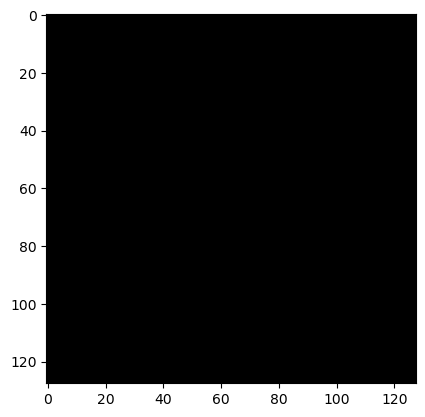

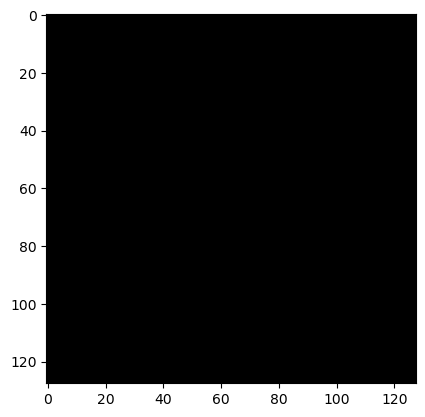

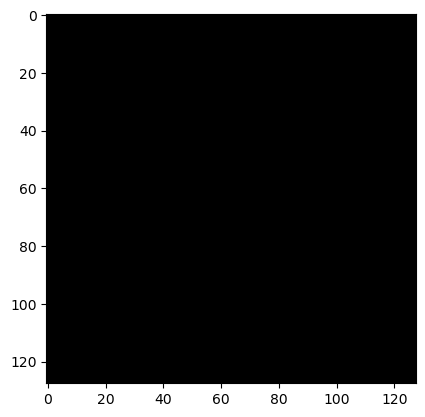

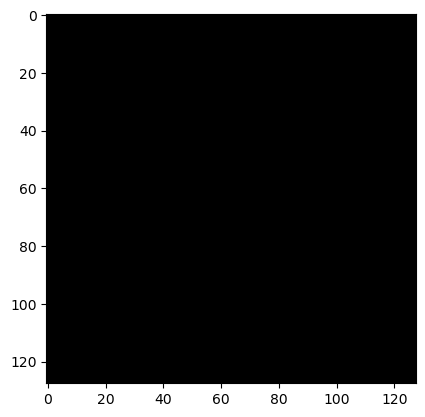

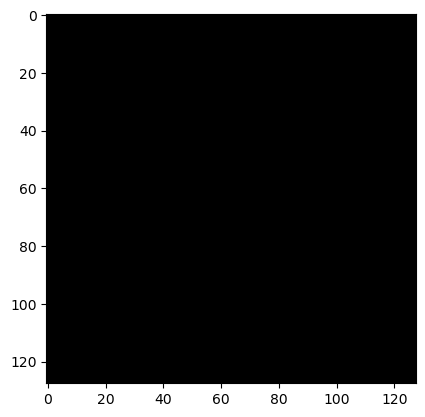

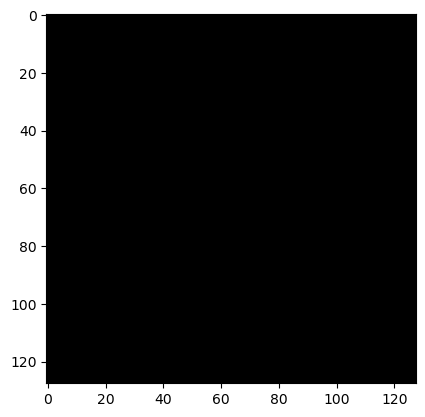

In [26]:
imdata = data.T.reshape(-1, 128, 128)
for i in range(6):
    plt.imshow(imdata[i], cmap="copper")
    plt.show()
# plt.savefig("data/0_f_k_2_SET_2-58-8_2024-10-10.png")